**Computer Vision**

**Computer Vision**

***Image Classification Model***

Algorithm to detect watermarks in images. Below is a CNN algorithm for water detection on photos of faces. I have used a Pytorch based library called Fastai.

In [1]:
# Importing important libraries.
import fastai
import numpy as np
from fastai.metrics import accuracy
from fastai.vision import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/My Drive/sqyrd_img/'

Now, we can ask the fast.ai to load all the data. I use from_folder function from class ImageDataBunch.

In [5]:
data = ImageDataBunch.from_folder(path, valid_pct=0.2, train = 'train', test = 'test',ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

I asked the function to not only load the data, but make two transformations. Firstly, it will do data augmentation by flipping the pictures horizontally, making some rotations and zoomings. By doing so, it can supply the model with more training data, and prevent the model from overfitting. Secondly, it will set the size of each image to 224*224.

In [6]:
data.train_ds, data.valid_ds, data.test_ds

(LabelList (792 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 raw,raw,raw,raw,raw
 Path: /content/drive/My Drive/sqyrd_img, LabelList (198 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 water,raw,raw,water,raw
 Path: /content/drive/My Drive/sqyrd_img, LabelList (199 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: EmptyLabelList
 ,,,,
 Path: /content/drive/My Drive/sqyrd_img)

Training data consists of 792 images, half watermarked and half raw pictures. Validation data consists of 198 images. In addition, test data has 199 images for prediction.

In [7]:
print(data.classes, data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds))

['raw', 'water'] 2 792 198 199


In [8]:
defaults.device = torch.device('cuda') # makes sure the gpu is used

It detects classes automatically as the images have been stored in separate folders named 'raw' and 'water' representing standard and watermarked images respectively. Let's view some random images from our data.

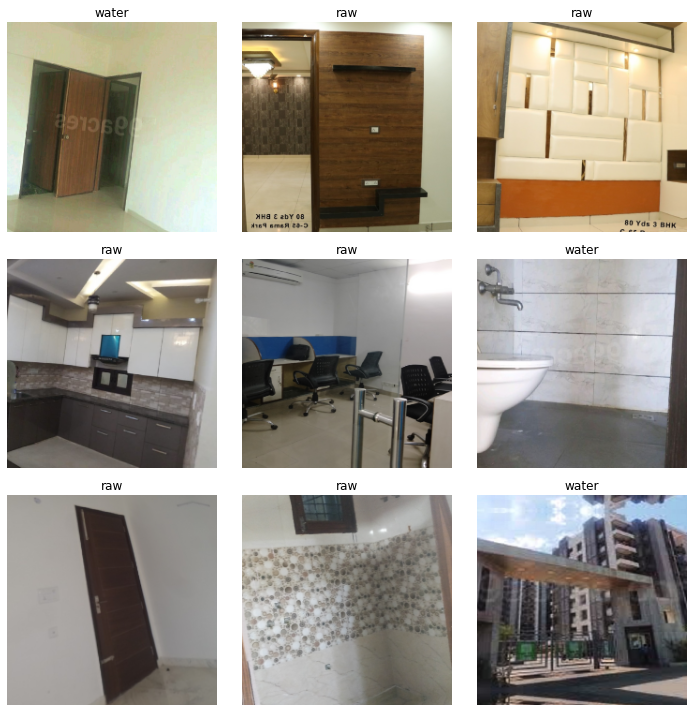

In [9]:
data.show_batch(rows=3, figsize=(10,10))

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

I asked the Convolutional Learner to receive the data we prepared, and the architecture will be a pre-trained model called resnet34, then to measure if it learned well, the metrics will be the accuracy.

In [12]:
learn.unfreeze() # must be done before calling lr_find

Above code unfreezes all the layers of resnet architecture so we can train it on our own data.

In [13]:
learn.lr_find() # We have to unfreezes firstly, before we call lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


This runs the model for 9 epochs and starts increasing the learnings rate and plots a graph between loss and learning rate.

Min numerical gradient: 8.32E-04
Min loss divided by 10: 4.37E-04


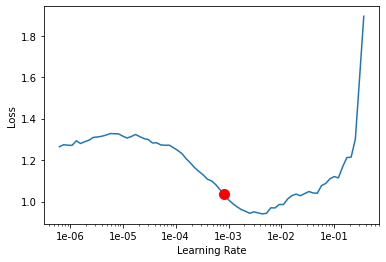

In [14]:
learn.recorder.plot(suggestion=True)

We can see from above graph that learning rate is decreasing from 1e-4 till it reraches 1e-3. After this, its starts to explode. So, I keep the learning rate between these two values for training.

In [15]:
learn.fit_one_cycle(20,max_lr=slice(1e-4, 1e-3))

Above code (fit_one_cycle) used a concept called one-cycle-policy. This varies the learning rate and momentum after each cycle so as to reach the minima in the least time. I have reached a validation accuracy of around 91%, which is pretty good considering I had very less number of images to train.

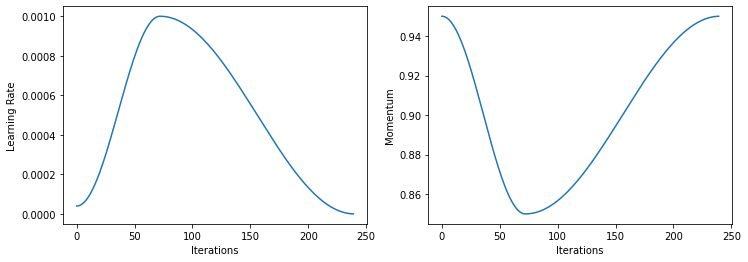

In [16]:
learn.recorder.plot_lr(show_moms=True)

Above plots show the change in learning rate and the momentum with the change in iterations. Now, I will save this model.

In [17]:
learn.save('model_fastai')

In [18]:
learn.load('model_fastai')

Learner(data=ImageDataBunch;

Train: LabelList (792 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
raw,raw,raw,raw,raw
Path: /content/drive/My Drive/sqyrd_img;

Valid: LabelList (198 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
water,raw,raw,water,raw
Path: /content/drive/My Drive/sqyrd_img;

Test: LabelList (199 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/sqyrd_img, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=Fals

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

This plots the confusion matrix showing the hits and misses on validation data.

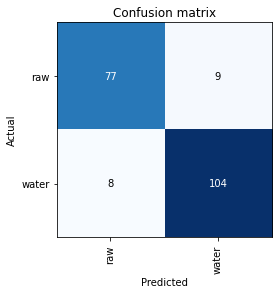

In [20]:
interp.plot_confusion_matrix()

Now, below code shows the top losses in our dataset.

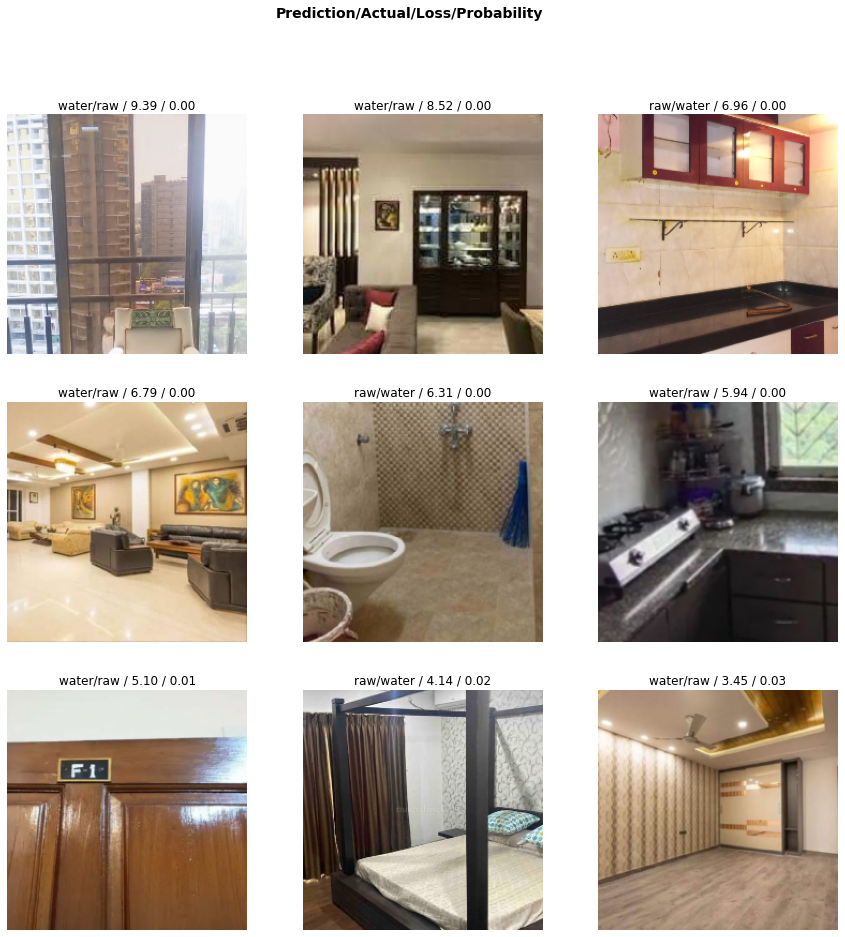

In [21]:
interp.plot_top_losses(9, figsize=(15,15))

Prediction: raw


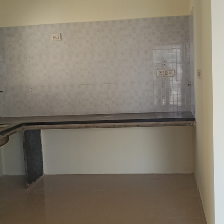

In [39]:
img = data.test_ds[67][0]
pred = learn.predict(img)[0]
print('Prediction:' , pred)
img

Now we are using our test dataset as validation set and make the predictions.

In [26]:
data_test = ImageDataBunch.from_folder(path, train = 'train', valid = 'test',ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [27]:
data_test.valid_ds

LabelList (199 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
raw,raw,raw,raw,raw
Path: /content/drive/My Drive/sqyrd_img

In [28]:
defaults.device = torch.device('cuda')

In [29]:
learn_test = cnn_learner(data_test, models.resnet34, metrics=accuracy, pretrained=True)

In [30]:
learn_test.load('model_fastai')

Learner(data=ImageDataBunch;

Train: LabelList (990 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
raw,raw,raw,raw,raw
Path: /content/drive/My Drive/sqyrd_img;

Valid: LabelList (199 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
raw,raw,raw,raw,raw
Path: /content/drive/My Drive/sqyrd_img;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [31]:
interp_test = ClassificationInterpretation.from_learner(learn_test)

Below is the confusion matrix for test set.

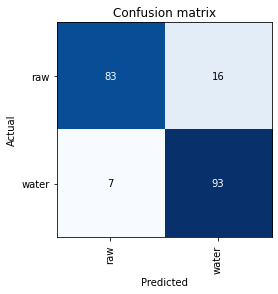

In [32]:
interp_test.plot_confusion_matrix()

In [33]:
learn_test.validate()

[0.63575673, tensor(0.8844)]

Model is validated on the test set, where accuracy is around 85%. Below are the predictions and the ground truth for the test images.

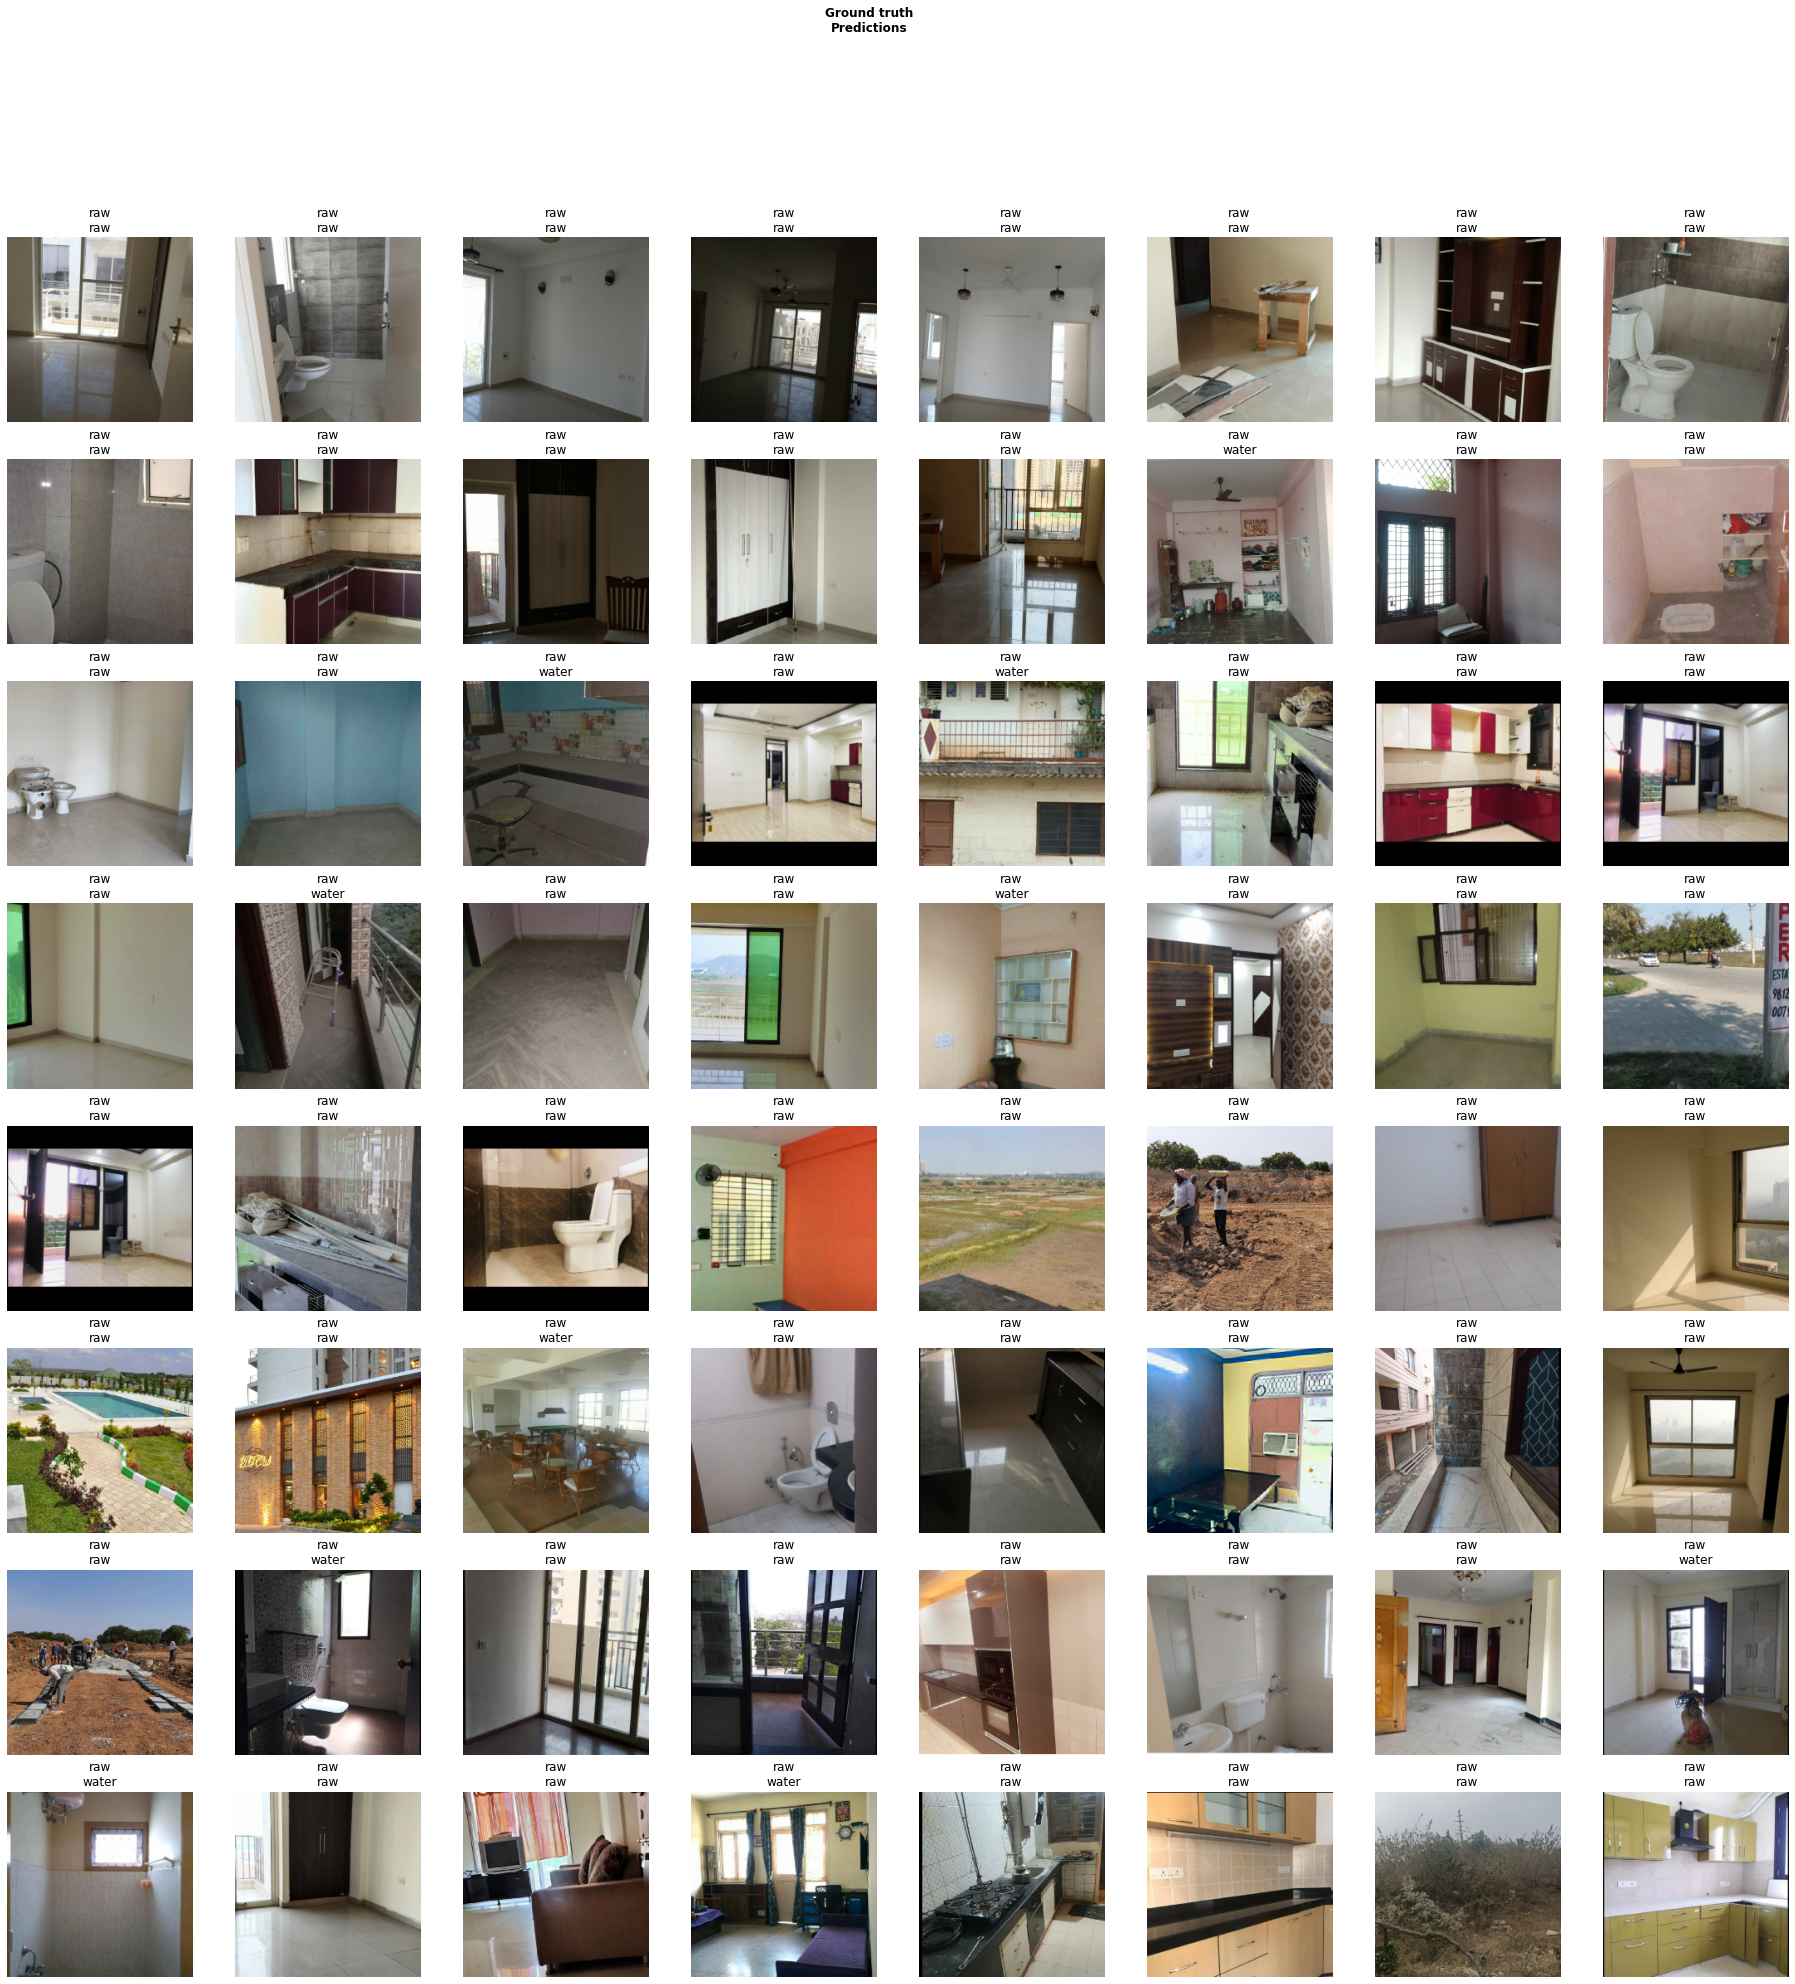

In [36]:
learn_test.show_results(rows=20)

So, my test accuracy is much nearer the training and validation accuracy. This means that the model is working well . Since the dataset is also having  less images, performance of the model is quite good. .